Smoke Sensor ID: 0xa16
FIFO samples 0
FIFO data 0xffff


<IPython.core.display.Javascript object>


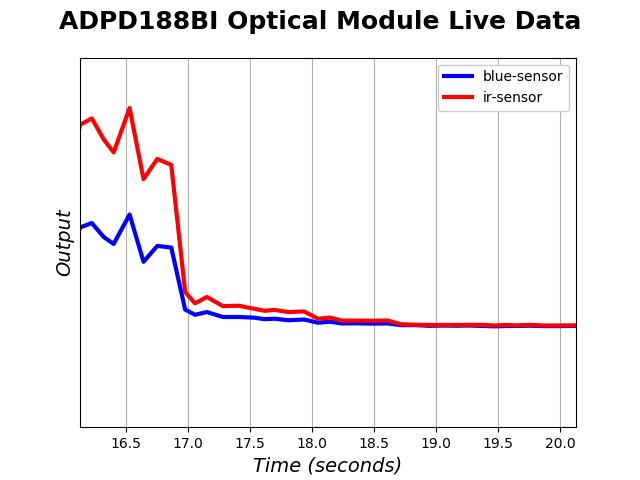

<IPython.core.display.Javascript object>


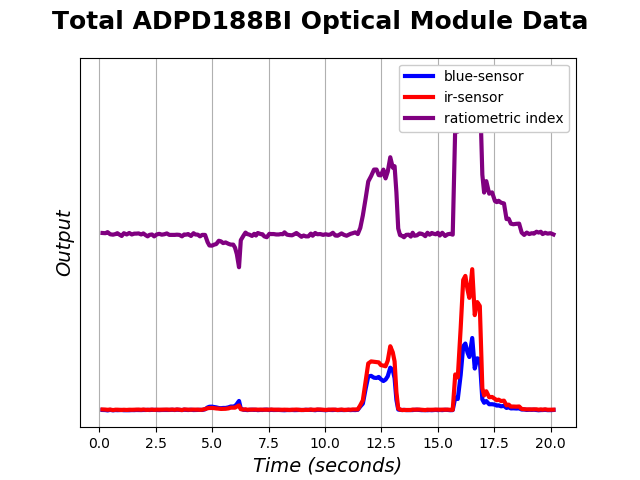

In [1]:
#
# AnalogMax: Smoke Sensor Demo
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time

#
# Please change here to proper COM port name
#
ser = serial.Serial('COM13', 115200)
#
# ADPD register access functions
#
def ADPD_write_reg(reg, value):
    ser.reset_input_buffer() #
    cmd = "<c8K%0.2xK%0.2xK%0.2xK>" % (reg, (value >> 8), (value & 0xFF))  # 
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value

def ADPD_read_reg(reg):
    ser.reset_input_buffer() #
    cmd = "<c8K%0.2xK<c9K..m..M>" % reg  # 
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(4)
    return int(s, 16)

def ADPD_read_fifo():
    fifolevel = ADPD_read_reg(0x00) >> 8
    # Do something if fifo level < 2 ?
    retval = ADPD_read_reg(0x60)
    retval = 1.0 * retval/16384
    return retval

# RNM 12/26/18: added reading, parsing, and writing of configuration file for programming registers from ADI script 
def ADPD_program_config_file(fname):
    # open config file for reading only
    f = open(fname, 'r')
    
    # read the lines into an array
    lines = f.readlines()
    
    # close the file
    f.close()
    
    # parse the array into tuples for register and data settings and program
    for line in lines:
        if not line.startswith('#'):    # eliminating comments from parse
            line = line[0:7]            # getting only the register and data from file
            line = line.split(' ')      # creating tuples
            line[0] = int(line[0], 16)  # hex to int conversion for each list
            line[1] = int(line[1], 16)
            
            ADPD_write_reg(line[0] ,line[1])  # program the registers one-by-one
                                              # note the space before the comma - required for correct format conversion

def ADPD_init():
# RNM 12/26/18 programming registers from configuration file
    ADPD_program_config_file("trenz.cfg")
# Change one setting
    ADPD_write_reg(0x11 ,0x3065) # Channel A,B, Average, 16 bit sum of channels
# Enter normal mode
    ADPD_write_reg(0x10 ,0x0002)
    
################################################################################
################################################################################
   
ser.flushInput()
ser.reset_input_buffer() #
#
ser.write(b'[6]')    # Select UHSA I2C Channel
ser.reset_input_buffer() #

#
# Check sensor ID
#
id = ADPD_read_reg(0x08)
print("Smoke Sensor ID:", hex(id))
#
# "Normal" Register Init
# 
ADPD_init()

print("FIFO samples", ADPD_read_reg(0x00) >> 8)
print("FIFO data", hex(ADPD_read_reg(0x60)))

#
# Plot Sensor FIFO read data
#
plt.ion() 
start_time = time()
timepoints = []
xdata = []
ydata = []
zdata = []

yrange = [0.0, 0.5] # RNM 1/03/19 arbitrary scaling for best plot picture
view_time = 4 # seconds of data to view at once
duration = 20 # total seconds to collect data

# RNM 1/03/19  plotting real-time blue and IR data only for 'view_time' duration
fig1 = plt.figure()
fig1.suptitle('ADPD188BI Optical Module Live Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Output', fontsize='14', fontstyle='italic')
plt.yticks([]) # RNM 1/03/19 no y axis enumeration required

line1, = plt.plot(xdata, color="blue", linewidth=3.0)   # RNM 1/03/19 changed line color and thickness
line2, = plt.plot(ydata, color="red", linewidth=3.0)    # RNM 1/03/19 changed line color and thickness
line3, = plt.plot(zdata, color="purple", linewidth=3.0) # RNM 1/03/19 changed line color and thickness

plt.legend((line1, line2), 
           ('blue-sensor', 'ir-sensor'), 
           loc='upper right',
           framealpha=1.0)

fig1.show()

plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # Flush junk

run = True

# collect the data and plot a moving frame
while run:
    
    try:
        x = ADPD_read_fifo()
        xdata.append(x)  # store the entire dataset for later
 
        y = ADPD_read_fifo()
        ydata.append(y) # store the entire dataset for later
        
        z = (x/y) 
        z = (1.0 - z) + 0.5 # RNM 1/03/19 inversion and offset for a cleaner plot
        zdata.append(z) # store the entire dataset for later

        
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted data
        line1.set_xdata(timepoints) 
        line1.set_ydata(xdata)
 
        line2.set_xdata(timepoints)
        line2.set_ydata(ydata)
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect+plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()
    
# RNM 1/03/19 total data plot with blue/ir index
fig2 = plt.figure()
fig2.suptitle('Total ADPD188BI Optical Module Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Output', fontsize='14', fontstyle='italic')
plt.yticks([]) # RNM 1/03/19 no y axis enumeration required  

plt.plot(timepoints, xdata, color="blue", linewidth=3.0)     # RNM 1/03/19 changed line color and thickness
plt.plot(timepoints, ydata, color="red", linewidth=3.0)      # RNM 1/03/19 changed line color and thickness
plt.plot(timepoints, zdata, color="purple", linewidth=3.0)   # RNM 1/03/19 changed line color and thickness

line3.set_xdata(timepoints) # RNM 1/03/2019 only plotting the ratio for the total plot
line3.set_ydata(zdata)      # RNM 1/03/2019 only plotting the ratio for the total plot

plt.legend((line1, line2, line3), 
           ('blue-sensor', 'ir-sensor', 'ratiometric index'), 
           loc='upper right',
           framealpha=1.0)

fig2.show()

#
# Blue LED will go off, also the GPIO0 LED
#
ADPD_write_reg(0x0F ,0x0001) # Issue Softreset

# close the serial port
ser.close()
